# Database Initialization

In [3]:
from __future__ import division
db = 'twitterGender'
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
myDB = URL(drivername='mysql', database=db, query={ 'read_default_file' : '/home/fatal/.my.cnf' })
engine = create_engine(name_or_url=myDB, encoding='utf8')
#conn = engine.connect()


# Necessary Libraries & Global Variables

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as ss
import pandas as pd
import warnings

import time
import pdb

#SMALL_VAL = 0.0000001
SMALL_VAL = 1
Zero = 0
RAND_COUNT = 5000
group_id_cnt = 0

# customized ks test
In this customized version we select maximum of 
1. difference of theoretical and empirical CDFs
2. theoretical CDF two tails' difference from zero (Tails for theoretical CDF are the exact match for smallest and greatest empirical values)

In [109]:
def my_kstest(rvs, cdf, args=(), N=20):

    cdf = getattr(ss, cdf).cdf
    vals = np.sort(rvs)
    N = len(vals)
    cdfvals = cdf(vals, *args)

    Dplus = (np.arange(1.0, N+1)/N - cdfvals).max()
    Dmin = (cdfvals - np.arange(0.0, N)/N).max()

    minTail = cdf(vals[0]-.00000001, *args)
    maxTail = 1 - cdf(vals[-1]+.00000001, *args)
    D = np.max([Dplus,Dmin,minTail,maxTail])

    pval_two = ss.kstwobign.sf(D*np.sqrt(N))
    if N > 2666 or pval_two > 0.80 - N*0.3/1000.0:
        return D, ss.kstwobign.sf(D*np.sqrt(N))
    else:
        return D, ss.ksone.sf(D,N)*2


# Find Best Fit Distribution
## Function name: best_fit_distribution
**Args:**
* data -> a series of data values (like group norms in our case)
* bins -> how many bins we want to divide the data into (default = 200)
* ax -> axes subplots (default None)
  * subplot of the data with x and y limits set
  * If given, this function will add histogram of data + all different distribution lines to this subplot

**Returns:**
* Best_Distribution_name -> winner among all distributions
* Best_SSE -> Minimum sum of squared error
* Best_params -> parameters of the best distribution which has at least two parameters of "Location" and "Scale" + any additional parameters based on the distribution type

**What it does?**
* Creates a histogram of the data divided to <BINS> bins
* Sets x as the center of each bin
* Sets y as the frequency value of each bin (normed = True)
* Finds the best fit distribution among previously defined distributions based on the SSE of the returned value and the actual value
  * Uses scipy.stats distribution methods **fit** and **pdf**
  * scipy.stats current Distributions are **norm**, **expon**, and **lognorm** for now
* If ax is set, it adds histogram and all the distributions lines with their MLE parameters to that

In [333]:
# Create models from data
def best_fit_distribution(input_data, ax=None, plot_pdf = False):
    """Model data by finding best fit distribution to data"""
    DISTRIBUTIONS = [
        ss.norm, ss.expon, ss.lognorm
    ]
    # Best holders
    best_distribution = ss.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    dist_stat = []
    # pdb.set_trace()
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                data = input_data
                if distribution.name == 'norm':
                    data = [max(data)*-1] + data
                # fit dist to data
                params = distribution.fit(data)
                #s3 = time.time()
                #if distribution.name == 'lognorm':
                #    logdata = np.log([x+SMALL_VAL for x in data])
                #    estimated_mu, estimated_sigma = ss.norm.fit(logdata)
                #    params = [estimated_sigma, 0, np.exp(estimated_mu)-SMALL_VAL]
                #    #params1 = distribution.fit(data, floc=0)
                #else:
                #    params = distribution.fit(data)
                

                
                #statistics, pval = ss.kstest(data, distribution.name, args=params)
                statistics, pval = my_kstest(data, distribution.name, args=params)
                dist_stat += [(distribution.name, round(statistics, 2), pval)]
                # if axis pass in add to plot
                try:
                    if ax:
                        # Separate parts of parameters
                        arg = params[:-2]
                        loc = params[-2]
                        scale = params[-1]
                        # Calculate fitted PDF and error with fit in distribution
                        if plot_pdf:
                            y = distribution.pdf(data, loc=loc, scale=scale, *arg)
                        else:
                            y = distribution.cdf(data, loc=loc, scale=scale, *arg)
                        pd.Series(y, data). \
                        plot(ax=ax, label=distribution.name + str(round(statistics, 4)))
                except Exception:
                    pass
                # identify if this distribution is better
                if best_sse > statistics:
                    best_distribution = distribution
                    best_params = params
                    best_sse = statistics

        except Exception as detail:
            print('Runtime Error: ' + str(detail))
            pass
    return (best_distribution.name, best_sse, best_params, dist_stat)

0.0112020171482
(0.53410166249043511, 0.00058846773416565943, 0.0092013019508480794)
args: 0.53410166249,0.498366756451,0.498311432795
scale: 0.00920130195085,0.00987239926399,0.00987252870733


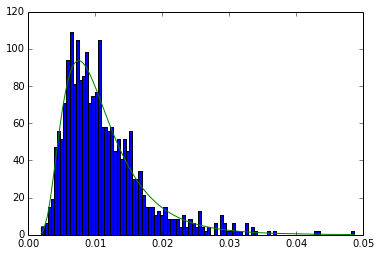

In [310]:
(0.30380735846871737, -0.016503482995620839, 0.024213960016335211)
data = ss.lognorm.rvs(0.5, loc=0, scale=0.01, size=1000)
params = ss.lognorm.fit(data)
print(np.mean(data))
logdata = np.log(data)
estimated_mu, estimated_sigma = ss.norm.fit(logdata)
logdata = np.log([x+0.000001 for x in data])
estimated_mu1, estimated_sigma1 = ss.norm.fit(logdata)
print(params)
print("args: " + str(params[0]) + "," + str(estimated_sigma) + "," + str(estimated_sigma1))
print("scale: " + str(params[2]) + "," + str(np.exp(estimated_mu)) + "," + str(np.exp(estimated_mu1)-0.000001))

a = plt.hist(data, bins=100, normed=1)
plt.plot(np.sort(data),ss.lognorm.pdf(np.sort(data),*params))

In [116]:
# Create models from data
def best_anderson_fit_distribution(input_data, ax=None, plot_pdf = False):
    """Model data by finding best fit distribution to data"""
    DISTRIBUTIONS = [
        ss.norm, ss.expon, ss.lognorm
    ]
    # Best holders
    best_distribution = ss.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    dist_stat = []
    # pdb.set_trace()
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                data = input_data
                if distribution.name == 'norm':
                    data = [max(data)*-1] + data

                # fit dist to data
                #s3 = time.time()
                # pdb.set_trace()
                if distribution.name == 'lognorm':
                    logdata = np.log(data)
                    statistics, critical_values, significance_level = ss.anderson(logdata, 'norm')
                else:
                    statistics, critical_values, significance_level = ss.anderson(data, distribution.name)
                    
                dist_stat += [distribution.name, round(statistics, 2), significance_level[2]]
                #s4 = time.time()              
                # if axis pass in add to plot
                try:
                    if ax:
                        #num_bins = 2000
                        #counts, bin_edges = np.histogram(data, bins=num_bins)
                        #pdb.set_trace()
                        #bin_edges = (bin_edges + np.roll(bin_edges, -1))[:-1]/2.0
                        #np.cumsum(counts), bin_edges[:-1]
                        # Calculate fitted PDF and error with fit in distribution
                        if distribution.name == 'lognorm':
                            logdata = np.log(data)
                            estimated_mu, estimated_sigma = ss.norm.fit(logdata)
                            params = [estimated_sigma, 0, np.exp(estimated_mu)]
                            #params1 = distribution.fit(data, floc=0)
                        else:
                            params = distribution.fit(data)
                        arg = params[:-2]
                        loc = params[-2]
                        scale = params[-1]
                        if plot_pdf:
                            y = distribution.pdf(data, loc=loc, scale=scale, *arg)
                        else:
                            y = distribution.cdf(data, loc=loc, scale=scale, *arg)
                        pd.Series(y, data). \
                        plot(ax=ax, label=distribution.name + str(round(statistics, 4)))
                    end
                except Exception:
                    pass
                # identify if this distribution is better
                if best_sse > statistics > 0:
                    best_distribution = distribution
                    best_params = 'params'
                    best_sse = statistics

        except Exception as detail:
            print('Runtime Error: ' + str(detail))
            pass
    return (best_distribution.name, best_sse, best_params, dist_stat)

# Distribution of best fit distributions among all different features

 Gives you count of features in each distribution
 And also best fitted distribution to each feature


In [327]:
def fetch_data(table_name, feat, feat_total_cnt, feat_needed_cnt, use_random=True):
    if use_random and group_id_cnt > RAND_COUNT:
        fetch_data_query = "select * from {0} join \
        (select ceil(rand()*{3}) as id from {0} where feat='{1}') as r2 using(id) limit {2}" \
        .format(table_name, feat, feat_needed_cnt, feat_total_cnt)
    else:
        fetch_data_query = "select * from {0} where feat = '{1}'" \
        .format(table_name, feat)
    raw_df = pd.read_sql(fetch_data_query, con=engine)
    return raw_df
    
    
def prepare_data(table_name, feat, feat_total_cnt, feat_needed_cnt, include_zero=True, use_random=True):
    raw_df = fetch_data(table_name, feat, feat_total_cnt, feat_needed_cnt, use_random)
    data = raw_df.group_norm.tolist()
    total_cnt = group_id_cnt
    if use_random and total_cnt > RAND_COUNT:
        total_cnt = RAND_COUNT
    nonExisting_cnt = max(0, int(total_cnt - len(data)))
    # Appending zero for those that does not use this feature at all
    # By removing this line you can find the best 
    if include_zero:
        data = data + ([Zero]*nonExisting_cnt)
    return np.sort(data).tolist()

def find_best_fit_for_all_feats(table_name, include_zero=True, useAnderson=False, use_random=True):
    DISTRIBUTIONS = [
        ss.norm, ss.expon, ss.lognorm
    ]
    pval_threshold = 0.05
    cntr = 1
    usr_best_fit = []
    query_time = 0
    fit_time = 0

    # Load DATA from DB
    stime = time.time()
    global group_id_cnt
    #pdb.set_trace()
    group_id_cnt = pd.read_sql('select count(distinct group_id) cnt from ' + table_name, con=engine)
    group_id_cnt = group_id_cnt.cnt[0]
    print(str(group_id_cnt) + ' data points for each feature')
    print(str(RAND_COUNT) + ' random data points will be selected instead, if it is smaller')
    # Load distinct features
    features = pd.read_sql('select feat, count(*) cnt from ' + table_name + ' group by feat', con=engine)
    feat_cnt = len(features)
    print(str(feat_cnt) + ' unique features' )
        
    if include_zero:
        rand_proportion = min(RAND_COUNT/group_id_cnt, 1)
    else:
        rand_proportion = 1
    #pdb.set_trace()
    # Load data feature by feature and find the best distribution for each feature
    for index, eachfeat in features.iterrows():
        feat = eachfeat.feat
        feat = feat.replace("'", "''").replace("%", "%%").replace('\\', '\\\\')
        qs = time.time()
        feat_datapoint_cnt = int(eachfeat.cnt * rand_proportion)
        data = prepare_data(table_name, feat, eachfeat.cnt, feat_datapoint_cnt, include_zero, use_random)
        qe = time.time()
        if useAnderson:
            best_fit_name, best_sse, best_fit_paramms, dist_stat = best_anderson_fit_distribution(data)
        else:    
            best_fit_name, best_sse, best_fit_paramms, dist_stat = best_fit_distribution(data)
        usr_best_fit.append([feat, eachfeat.cnt, feat_datapoint_cnt, best_fit_name, best_sse, best_fit_paramms,\
                            dist_stat])
        beste = time.time()
        query_time += (qe-qs)
        fit_time += (beste-qe)
        x = str(cntr) + ' out of ' + str(feat_cnt) + ', ' + feat + '-> query exec: ' \
        + str(round(qe-qs)) + 's, fit: ' + str(round(beste-qe)) + 's'
        print '\r', x, 
        #print x
        cntr += 1
    etime = time.time()
    print
    print('overall time: ' + str(round(etime-stime)) + 's -> query exec: ' + str(round(query_time)) + \
          's , fit: ' + str(round(fit_time)) + 's') 
    df = pd.DataFrame(usr_best_fit, \
                      columns=['feat', 'total_cnt', 'nonzero_cnt', 'best_fitted',  \
                               'best_statistic', 'best_params', 'dist_stat'])
    feat_dist = df.groupby('best_fitted').feat.count()
    print(feat_dist)

    df = df.sort_values('best_statistic')
    return df

# Draw Two plots for the data
One including all tested distributions and the other the best fitted one

**Args:**
* table_name -> to fetch data from
* feature -> specific feature that we want to fetch data for

**What it does?**
draws two plots for this data
* First one contains all the distributions over the histogram of the data with their MLE parameters.
For this we call function best_fit_distribution with a previously initiated subplot ax with the data ranges.
* Second one contains the winner, the fitted distribution with minimum SSE among all.
For this we generate a pdf out of 10000 samples using the parameters of the winning distribution and draw it.

In [119]:
def draw_plots(data, title, useAnderson=False, plot_pdf=False):
    """Draw plot including real data cdf and also all distributions' cdfs"""
    plt.figure(figsize=(12,8))
    sorted_data = np.sort(data).tolist()
    if plot_pdf:
        plt.hist(sorted_data, bins=200, normed=True, alpha=0.2, color='purple')
    else:
        N = len(sorted_data)
        frequencies = np.arange(1, N+1)/N
        plt.plot(sorted_data, frequencies, color='black', linewidth='3')
        
    ax=plt.subplot(111)
    # Save plot limits
    dataYLim = ax.get_ylim()
    dataXLim = ax.get_xlim()
    
    # Find best fit distribution
    if useAnderson:
        best_fit_name, best_sse, best_fit_paramms, dist_stat = \
        best_anderson_fit_distribution(sorted_data, ax, plot_pdf)
    else:
        best_fit_name, best_sse, best_fit_paramms, dist_stat = best_fit_distribution(sorted_data, ax, plot_pdf)
    ax.legend(loc='upper right')
    best_dist = getattr(ss, best_fit_name)

    # Update plots
    data_array=np.asarray(data)    
    num_of_zeros = len(data_array[data_array==Zero])
    ax.set_ylim(dataYLim)
    ax.set_xlim(dataXLim)
    ax.set_title(str(title) + ',' + best_fit_name + '\n ' + str(num_of_zeros) + '\n All Fitted Distributions')
    ax.set_xlabel('Group Norm')
    ax.set_ylabel('Frequency')
    plt.show()
    plt.close()
    return (best_fit_name, best_sse, best_fit_paramms)


# Putting all together

In [80]:
def dist_plus_nBestWorst(table_name, n=4, include_zero=True, plot_pdf=True, anderson=False):
    df = find_best_fit_for_all_feats(table_name, include_zero, anderson)
    print('\n 4 Best Fitted Distributions')
    for idx, eachRow in df.head(n).iterrows():
        data = prepare_data(table_name, str(eachRow.feat), eachRow.total_cnt, eachRow.nonzero_cnt, include_zero)
        draw_plots(data, str(eachRow.feat))
        draw_plots(data, str(eachRow.feat), plot_pdf=plot_pdf)
    print('\n 4 Worst Fitted Distributions')
    for idx, eachRow in df.tail(n).iterrows():
        data = prepare_data(table_name, str(eachRow.feat), eachRow.total_cnt, eachRow.nonzero_cnt, include_zero)
        draw_plots(data, str(eachRow.feat))
        draw_plots(data, str(eachRow.feat), plot_pdf=plot_pdf)
    return df

# LIWC County Level

999 data points for each feature
5000 random data points will be selected instead, if it is smaller
64 unique features
64 out of 64, YOU-> query exec: 0.0s, fit: 0.0s
overall time: 11.0s -> query exec: 1.0s , fit: 11.0s
best_fitted
expon       1
lognorm    26
norm       37
Name: feat, dtype: int64

 4 Best Fitted Distributions


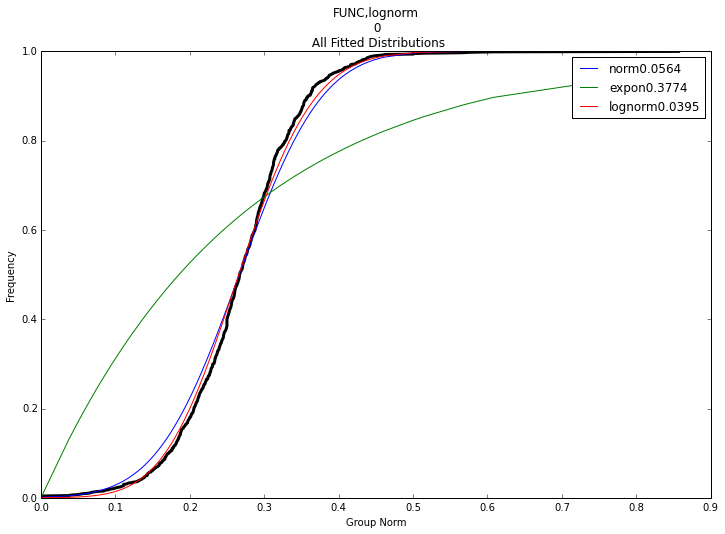

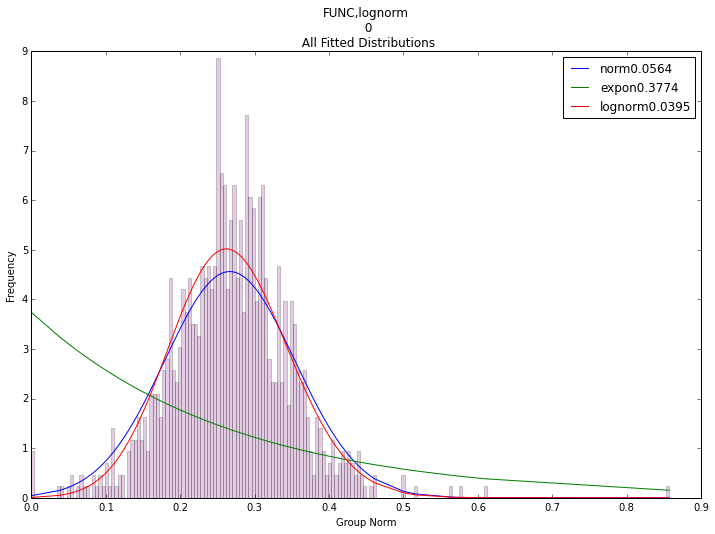

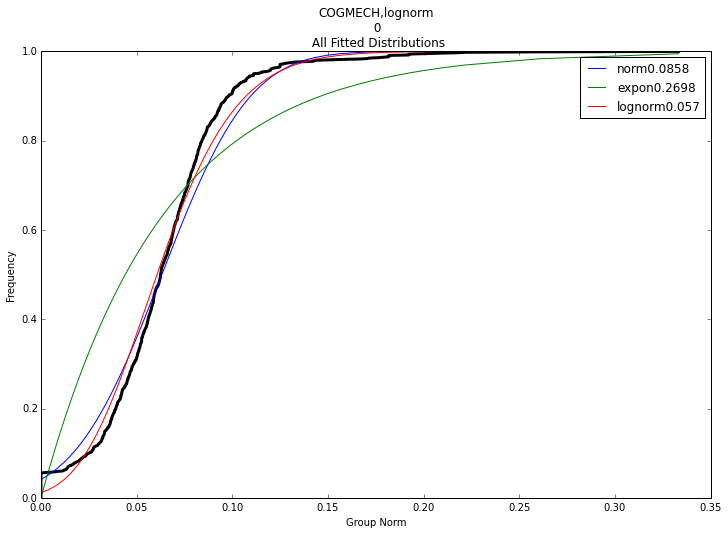

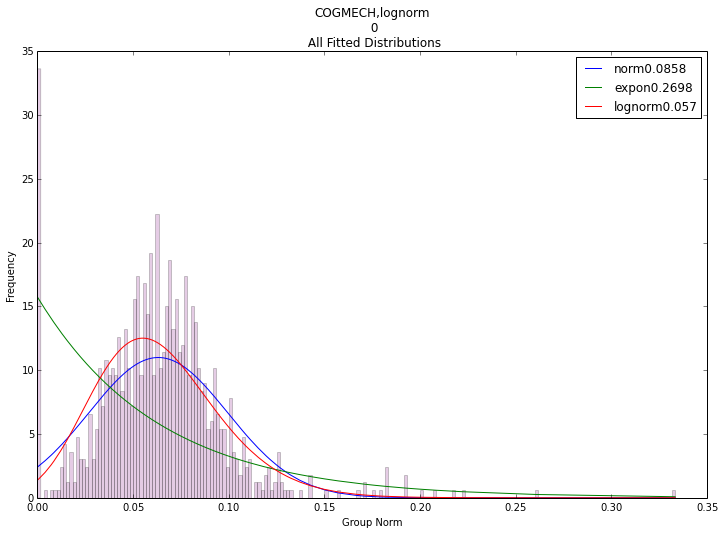

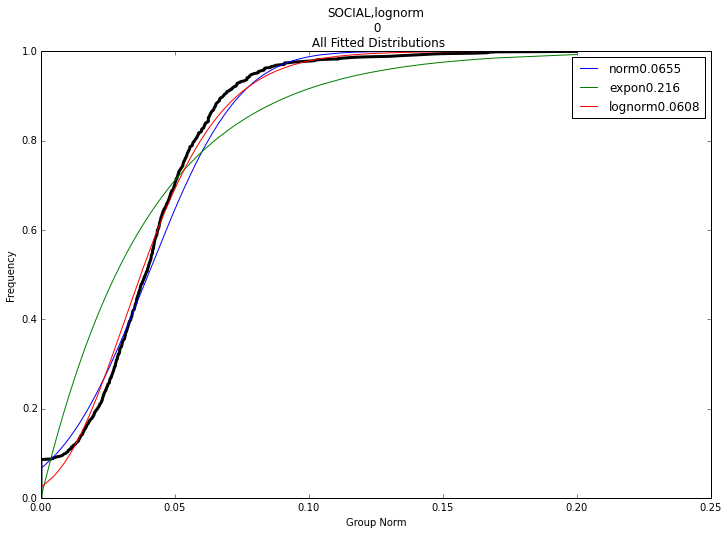

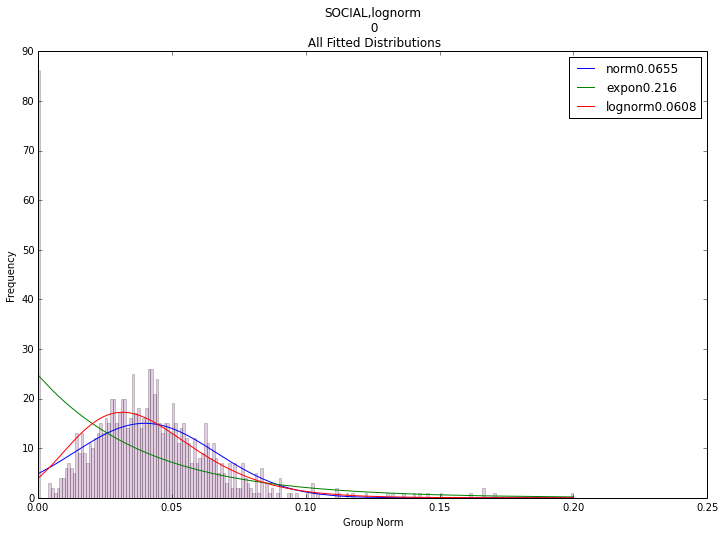

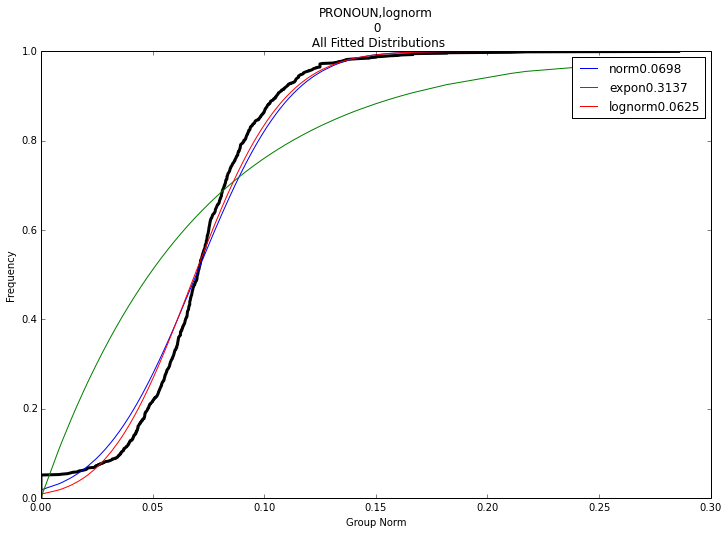

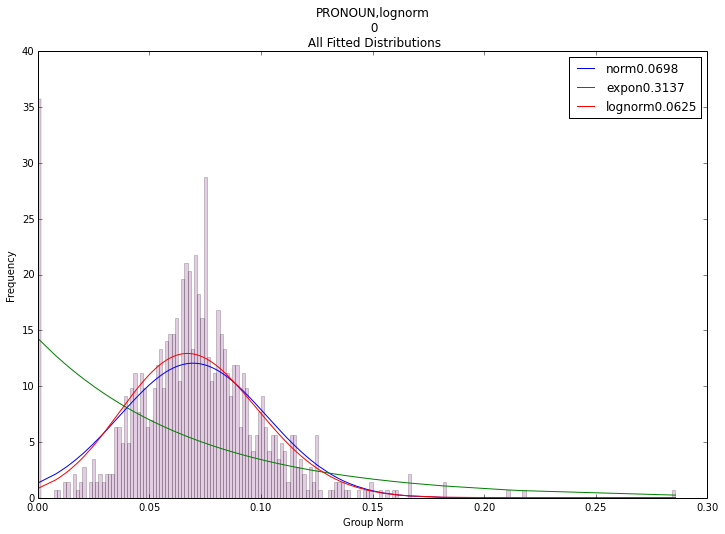


 4 Worst Fitted Distributions


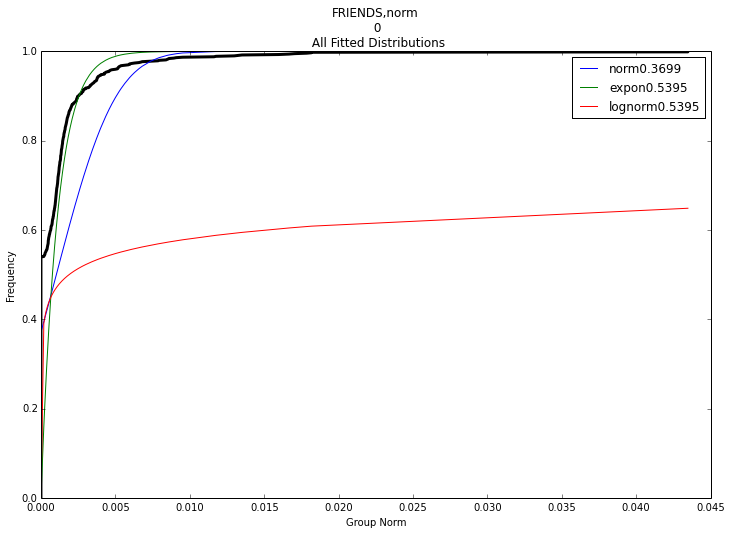

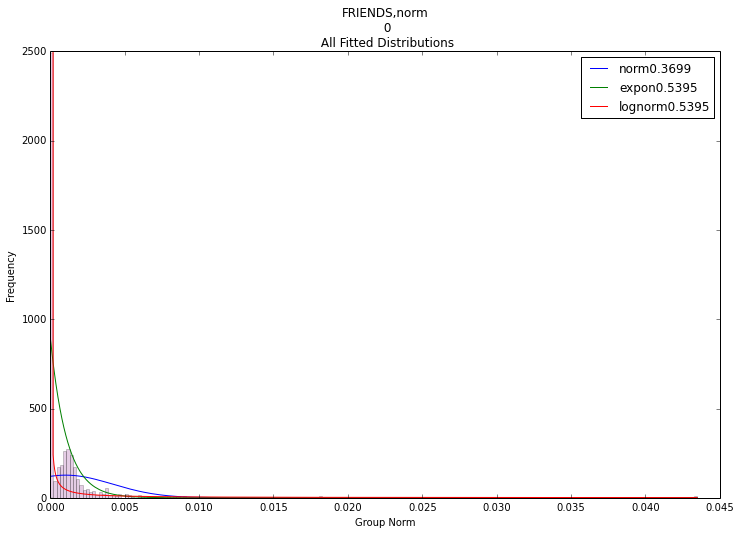

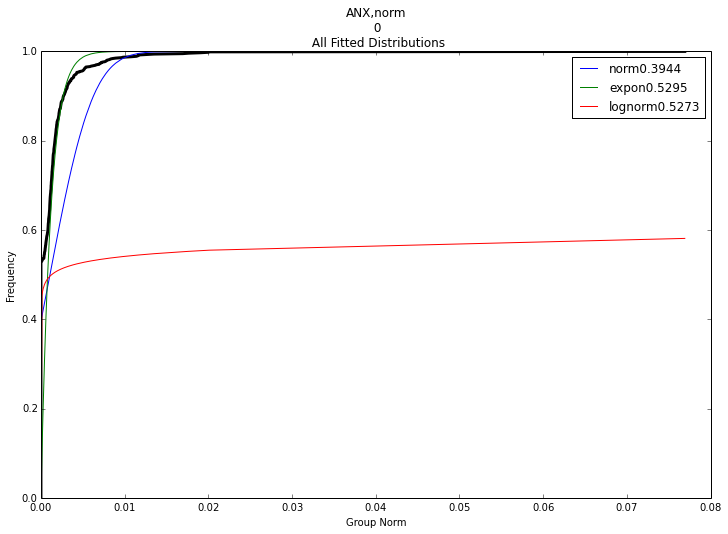

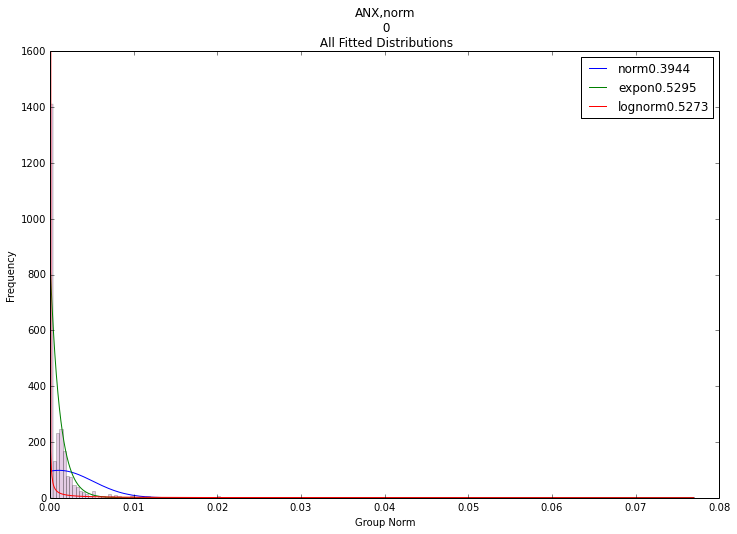

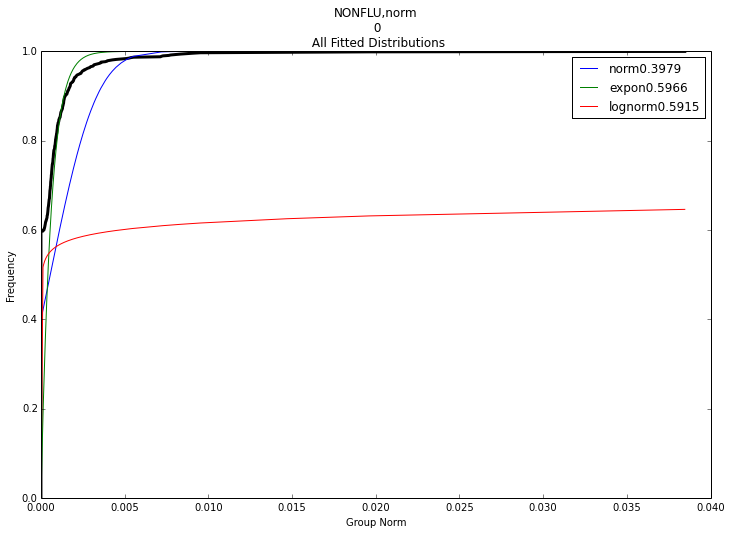

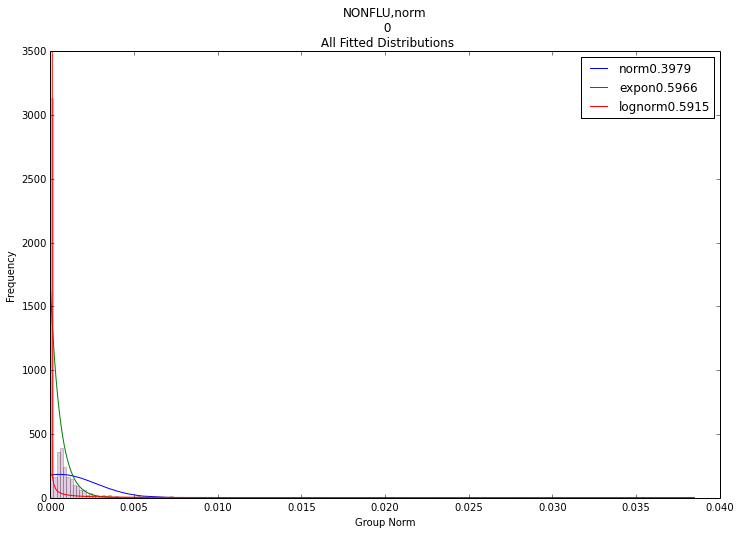

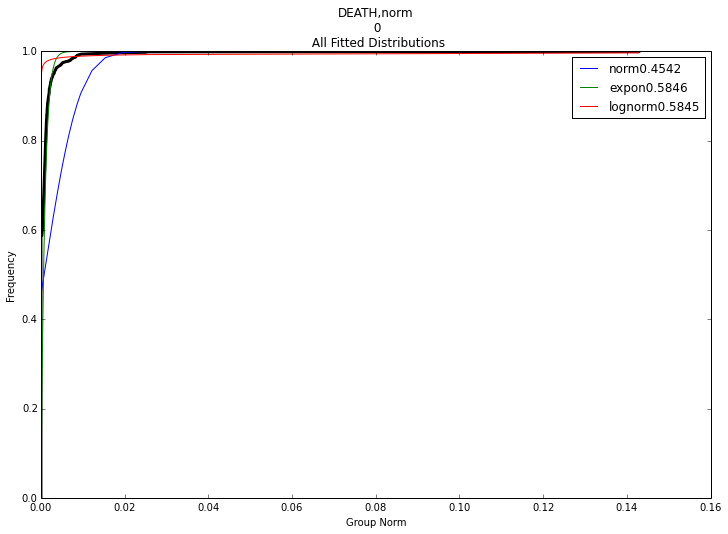

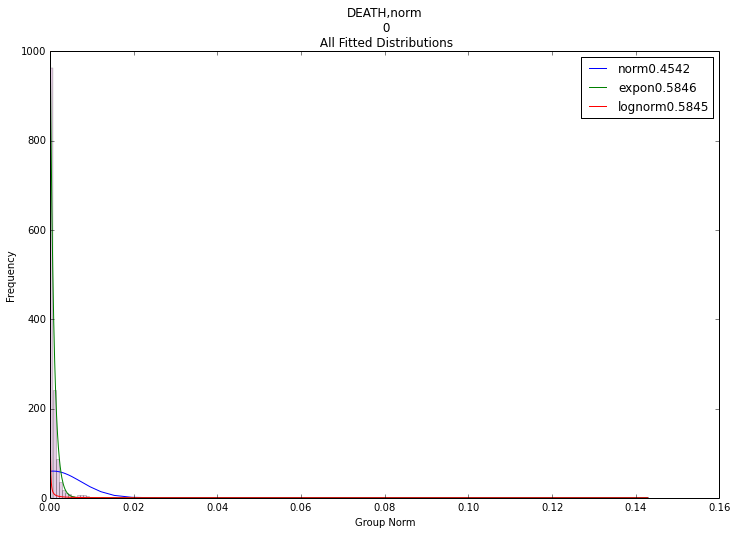

In [334]:
df_liwc_cnty_wZero = dist_plus_nBestWorst('feat$cat_LIWC2007$msgs_cnty_r1k$cnty$16to16')
#df_liwc_cnty_noZero = dist_plus_nBestWorst('feat$cat_LIWC2007$msgs_cnty_r1k$cnty$16to16', include_zero=False)

# LIWC User Level

In [ ]:
df_liwc_user_wZero = dist_plus_nBestWorst('feat$cat_LIWC2007$msgs_cnty_r1k$user_id$16to16', \
                                          include_zero=True, anderson = False)
print(df_liwc_user_wZero['dist_stat'])
#df_liwc_user_noZero = dist_plus_nBestWorst('feat$cat_LIWC2007$msgs_cnty_r1k$user_id$16to16', \
                                           include_zero=False, anderson = False)
#print(df_liwc_user_noZero['dist_stat'])

Just for test

[ 54.22511652  44.99059395  28.66395805  22.16285416  19.13393076
  15.5878741   11.45080799  10.2687891    9.60390347   8.79126549]
[ 16.59644129  16.59644129  20.69722044  20.69722044  20.69722044
  21.01659162  21.04439111  21.04439111  21.04439111  21.37204254]


(0, 0.01)

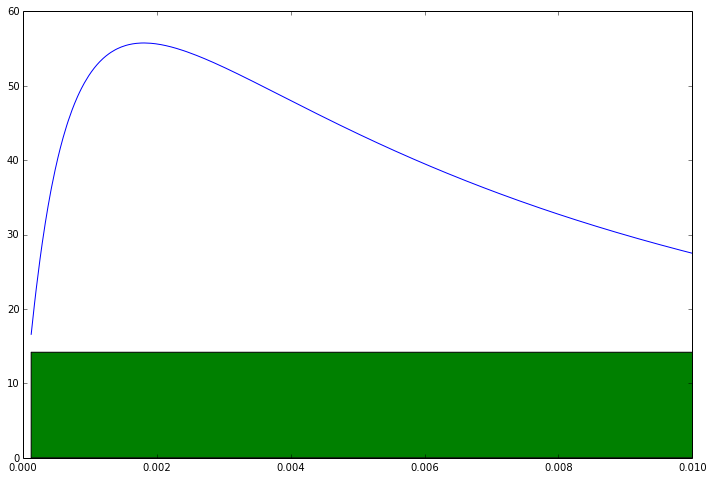

In [321]:
table_name = 'feat$cat_LIWC2007$msgs_cnty_r1k$user_id$16to16'
func = df_liwc_user_wZero[df_liwc_user_wZero.feat == 'SPACE'].iloc[0]
data = prepare_data(table_name, str(func.feat), func.total_cnt, func.nonzero_cnt, include_zero=False, use_random=True)
all_data = prepare_data(table_name, str(func.feat), func.total_cnt, func.nonzero_cnt, include_zero=False, use_random=False)
data_zero = prepare_data(table_name, str(func.feat), func.total_cnt, func.nonzero_cnt, include_zero=True, use_random=True)
all_zero = prepare_data(table_name, str(func.feat), func.total_cnt, func.nonzero_cnt, include_zero=True, use_random=False)
#print("************************ KS RANDOM DATA PDF ************************")
#params1 = draw_plots(data, str(func.feat), useAnderson=False, plot_pdf=True)
#print("************************ KS RANDOM DATA CDF ************************")
#params = draw_plots(data, str(func.feat), useAnderson=False, plot_pdf=False)
#print("************************ ANDERSON RANDOM DATA CDF ************************")
#params2 = draw_plots(data, str(func.feat), useAnderson=True, plot_pdf=False)
#print("************************ KS ALL DATA PDF ************************")
#params4 = draw_plots(data, str(func.feat), useAnderson=False, plot_pdf=True)
#print("************************ KS ALL DATA CDF ************************")
#params3 = draw_plots(all_data, str(func.feat), useAnderson=False, plot_pdf=False)
#print("************************ ANDERSON ALL DATA CDF ************************")
#params5 = draw_plots(all_data, str(func.feat), useAnderson=True, plot_pdf=False)
 # Calculate fitted PDF and error with fit in distribution
sorted_data = np.sort(data)
y = ss.lognorm.pdf(sorted_data, loc=params[2][-2], scale=params[2][-1], *params[2][:-2])
hist, edgs = np.histogram(sorted_data, 200, normed=True)
print(hist[0:10])
print(y[0:10])
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
plt.plot(sorted_data, y, label='lognorm')
plt.hist(sorted_data, normed=1)
ax.set_xlim(0, 0.01)

0.999999999
0.990281816505
mean: 0.009980633669
std: 0.00495040601573
[ 3.10244631  3.11120049  3.13534561  3.17376597  3.44343339  3.6614754
  3.81090361  4.13627065  4.43441192]
[ 0.99904036  0.99906836  0.99914174  0.99924763  0.99971281  0.99987462
  0.99993077  0.99998235  0.99999538]
[  4.81463649e-04   1.44439095e-03   2.40731825e-03 ...,   1.99759268e+00
   1.99855561e+00   1.99951854e+00]
[        -inf -16.10745682 -14.76630426 ...,  -0.02215544  -0.02214241
  -0.02213779]


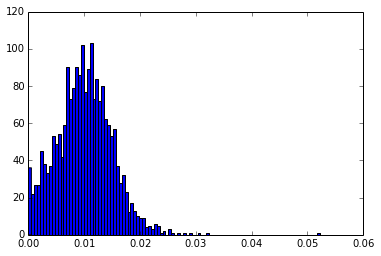

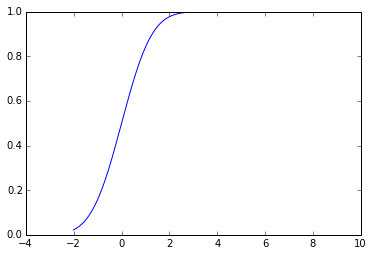

In [445]:
print(0.999999999)
d = ss.norm.rvs(size=100)
dcdf=ss.norm.cdf(np.sort(d))
print(dcdf[-1])
raw_df = pd.read_sql("select * from feat$cat_LIWC2007$msgs_r2k$user_id$16to16 where feat = 'NEGATE'", con=engine)
x = prepare_data(raw_df, True)
plt.hist(x, bins=100)
y = np.sort(x)
N=len(y)
xbar = np.mean(x, axis=0)
print('mean: '+str(xbar))
s = np.std(x, ddof=1, axis=0)
print('std: ' + str(s))
w = (y - xbar) / s
z = ss.norm.cdf(w)
plt.figure()
plt.plot(w, z)
i = np.arange(1, N + 1)
A2 = -N - np.sum((2*i - 1.0) / N * (np.log(z) + np.log(1 - z[::-1])), axis=0)
print(w[-10:-1])
print(z[-10:-1])
print((2*i - 1.0) / N )
print((np.log(z) + np.log(1 - z[::-1])))

